In [12]:
# import radians function from math package
from math import radians, cos, sin, asin, sqrt, atan2
import pandas as pd
from sklearn.cluster import KMeans

# get distance from latitude and longitude
def get_distance(lat1, lon1, lat2, lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance*1000

def df_transform(df):
    df = df.drop_duplicates()

    # limit the data to the area of interest
    df = df[(df['longitude'] > 115.875363) & (df['longitude'] < 117.351154) & (df['latitude'] > 39.482463) & (df['latitude'] < 40.315493)]
    df.loc[(df['latitude'] == 0) & (df['longitude'] == 0)]

    df['distance'] = 0
    df['time'] = 0
    df['speed'] = 0
    for i in range(1, len(df)):
        if(df.iloc[i]['taxi ID'] == df.iloc[i-1]['taxi ID']):
            df.iloc[i, df.columns.get_loc('distance')] = get_distance(df.iloc[i]['latitude'], df.iloc[i]['longitude'], df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
            df.iloc[i, df.columns.get_loc('time')] = (pd.to_datetime(df.iloc[i]['date time']) - pd.to_datetime(df.iloc[i-1]['date time'])).total_seconds()
            if df.iloc[i]['time'] > 0:
                df.iloc[i, df.columns.get_loc('speed')] = df.iloc[i]['distance'] / df.iloc[i]['time']

    return df

# apply k-means clustering
def kmeans(df, n_clusters):
    X = df[['distance', 'longitude', 'latitude', 'speed', 'time']].values
    # apply k-means clustering
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

    # get the labels
    labels = kmeans.labels_

    # # add the labels to the data
    df2 = df.copy()
    df2['labels'] = labels

    return df2



In [14]:
start = int(input("From: "))
end = int(input("To: "))
for hour in range(start, end):
    df = pd.read_csv('data/hours/{}H.txt'.format(hour), header=None, names=['taxi ID', 'date time', 'longitude', 'latitude'])  
    df = df_transform(df)
    print('transform ok')
    df = kmeans(df, 3)
    print('kmeans ok')
    for index, row in df.iterrows():
        if(row['labels'] != 0):
            print(index)
            with open('data/hours/labeled/{}H.txt'.format(hour), 'a') as f:
                f.write(str(row['date time']) + ',' + str(row['longitude']) + ',' + str(row['latitude']) + ',' + str(row['labels']) + '\n')

transform ok
kmeans ok
6
9


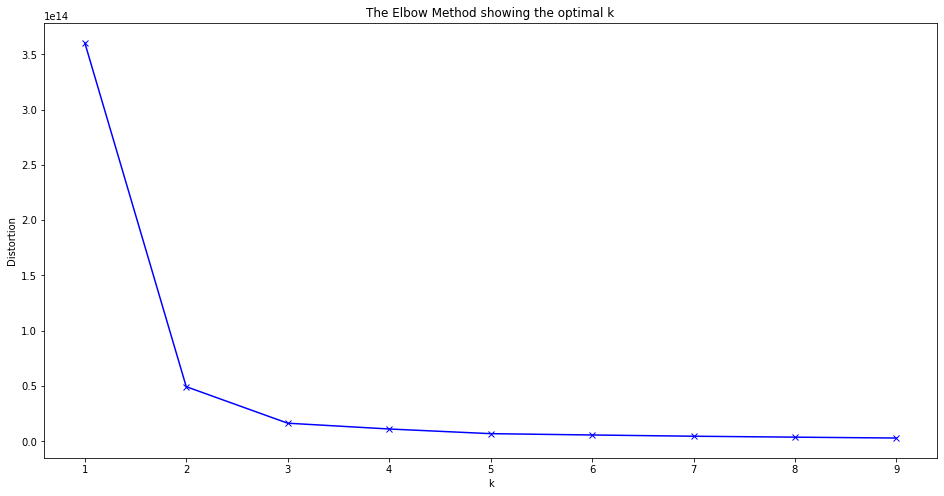

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df[['distance', 'longitude', 'latitude', 'speed', 'time']])
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()